<a href="https://colab.research.google.com/github/Pavani-Banothu/CodeClause/blob/main/Satellite_image_classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
all_ds=tfds.load("eurosat",with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteR4A171/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds=tfds.load("eurosat",split="train[:60%]")
test_ds=tfds.load("eurosat",split="train[60%:80%]")
valid_ds=tfds.load("eurosat",split="train[80%:]")

In [ ]:
class_names=all_ds[1].features["label"].names
print(len(class_names))
print(class_names)

10
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
num_examples=all_ds[1].splits["train"].num_examples
print(num_examples)

27000


Text(0.5, 1.0, 'Bar plot showing number of samples on each class')

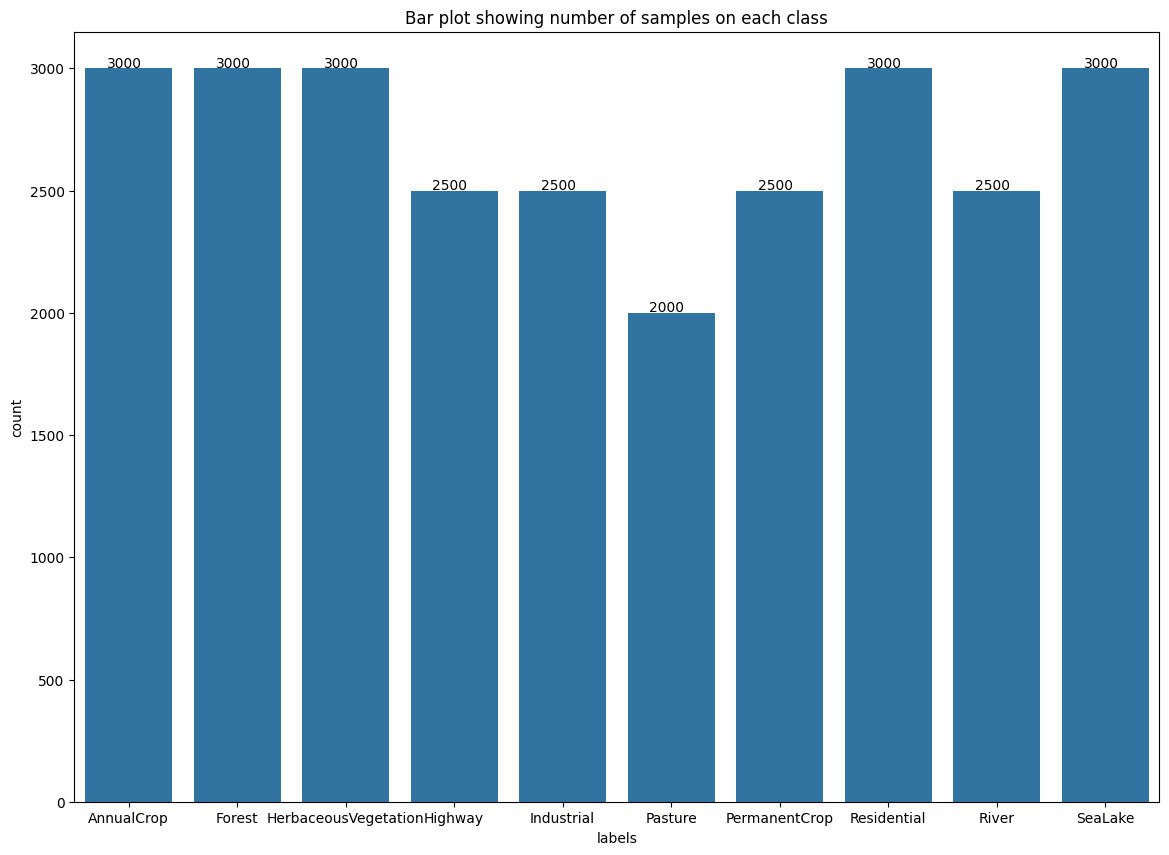

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,10))
labels ,count=np.unique(np.fromiter(all_ds[0]["train"].map(lambda x:x["label"]),np.int32),return_counts=True)
plt.ylabel('count')
plt.xlabel('labels')
sns.barplot(x=[class_names[i] for i in labels],y=count,ax=ax)
for i,x in enumerate(labels):
  ax.text(x-0.2,count[i]+5,count[i])
ax.set_title("Bar plot showing number of samples on each class")

In [ ]:
def  prepare_for_training(ds,cache=True,batch_size=64,shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache,str):
      ds=ds.cache(cache)
    else:
      ds=ds.cache()
  ds=ds.map(lambda d:(d["image"],tf.one_hot(d["label"],len(class_names))))
  ds=ds.shuffle(buffer_size=shuffle_buffer_size)
  ds=ds.repeat()
  ds=ds.batch(batch_size)
  ds=ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds


In [ ]:
batch_size=64
train_ds=prepare_for_training(train_ds,batch_size=batch_size)
valid_ds=prepare_for_training(valid_ds,batch_size=batch_size)

In [ ]:
for i in valid_ds.take(1):
  print(i[0].shape,i[1].shape)
for j in train_ds.take(1):
  print(j[0].shape,i[1].shape)

(64, 64, 64, 3) (64, 10)
(64, 64, 64, 3) (64, 10)


In [ ]:
batch=next(iter(train_ds))
print(batch)

(<tf.Tensor: shape=(64, 64, 64, 3), dtype=uint8, numpy=
array([[[[247, 182, 154],
         [246, 180, 154],
         [241, 175, 151],
         ...,
         [158, 132, 131],
         [154, 124, 122],
         [154, 124, 122]],

        [[239, 177, 154],
         [240, 178, 155],
         [237, 175, 154],
         ...,
         [162, 132, 130],
         [154, 124, 122],
         [156, 125, 123]],

        [[226, 173, 157],
         [224, 171, 155],
         [220, 164, 149],
         ...,
         [160, 126, 124],
         [158, 124, 122],
         [157, 123, 121]],

        ...,

        [[188, 133, 128],
         [188, 133, 128],
         [186, 131, 126],
         ...,
         [171, 130, 124],
         [171, 132, 125],
         [156, 119, 111]],

        [[193, 136, 129],
         [192, 135, 128],
         [190, 133, 126],
         ...,
         [163, 128, 122],
         [168, 133, 127],
         [150, 115, 109]],

        [[197, 138, 130],
         [195, 136, 128],
         [192, 135

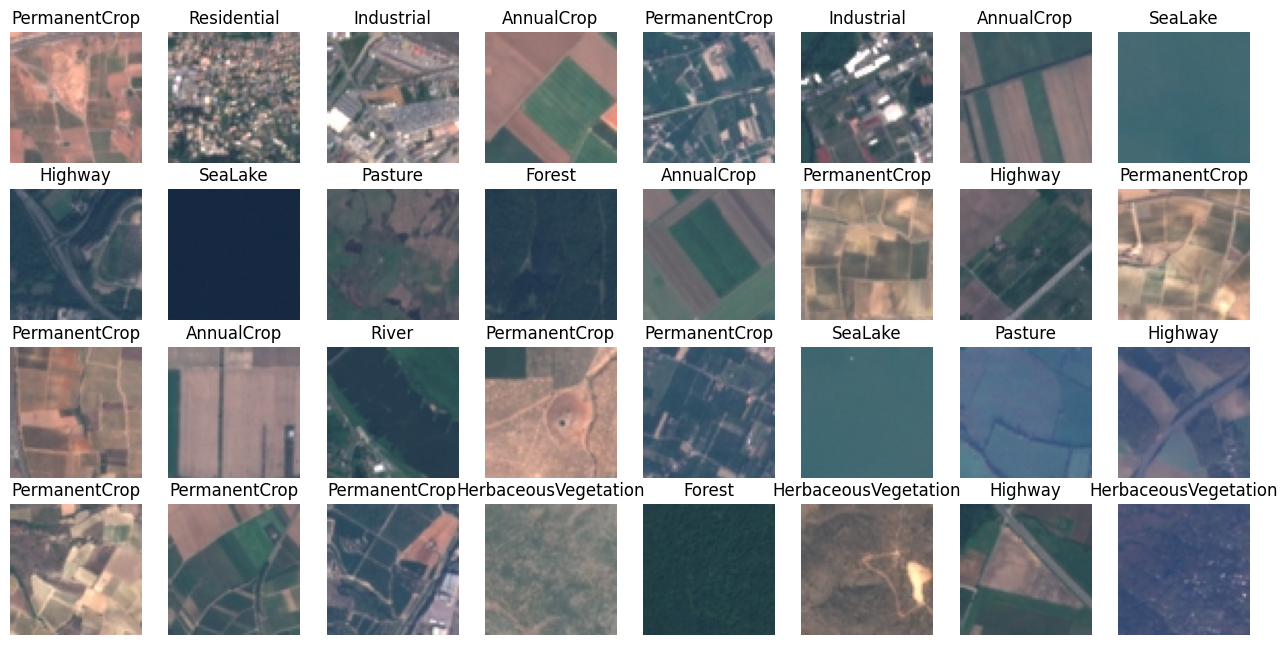

In [ ]:
def show_batch(batch):
  plt.figure(figsize=(16,16))
  for i in range(min(32,batch_size)):
    ax=plt.subplot(batch_size//8,8,i+1)
    plt.imshow(batch[0][i])
    plt.title(class_names[tf.argmax(batch[1][i].numpy())])
    plt.axis("off")
    plt.savefig("sample_images.png")
show_batch(batch)

In [ ]:
url_link = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"

In [ ]:
keras_layer= hub.KerasLayer(url_link, output_shape=[1280], trainable=True)

In [ ]:
model= tf.keras.Sequential([
  keras_layer,
  tf.keras.layers.Dense(len(class_names), activation="softmax")
])

In [ ]:
model.build([None, 64, 64, 3])

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", tfa.metrics.F1Score(len(class_names))]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              117746848 
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 117759658 (449.22 MB)
Trainable params: 117247082 (447.26 MB)
Non-trainable params: 512576 (1.96 MB)
_________________________________________________________________


In [ ]:
model.save("satellite_image_classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_name = "satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)


In [ ]:
n_training_steps   = int(num_examples * 0.6) // batch_size
n_validation_steps = int(num_examples * 0.2) // batch_size

In [ ]:
s= model.fit(
    train_ds, validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, epochs=5,
    callbacks=[model_checkpoint]
)

Epoch 1/5
 33/253 [==>...........................] - ETA: 2:10 - loss: 0.9772 - accuracy: 0.6974 - f1_score: 0.6797

In [ ]:
plt.subplot(2,1,1)
plt.plot(s.history["accuracy"],label="accuracy")
plt.plot(s.history["f1_score"],label="f1_score")
plt.legend()
plt.subplot(2,1,2)
plt.plot(s.history["loss"],label="loss")
plt.plot(s.history["val_loss"],label="val_loss")
plt.legend()
plt.show()

In [ ]:
n_testing_steps = int(all_ds[1].splits["train"].num_examples * 0.2)

In [ ]:
model.load_weights(model_path)

In [ ]:
images = np.array([ d["image"] for d in test_ds.take(n_testing_steps) ])
print("images.shape:", images.shape)

images.shape: (5400, 64, 64, 3)


In [ ]:
labels = np.array([ d["label"] for d in test_ds.take(n_testing_steps) ])
print("labels.shape:", labels.shape)

labels.shape: (5400,)


In [ ]:
predictions = model.predict(images)

169/169 [==============================] - 14s 63ms/step


In [ ]:
predictions = np.argmax(predictions, axis=1)
print("predictions.shape:", predictions.shape)

predictions.shape: (5400,)


In [ ]:
from sklearn.metrics import f1_score

accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions)
print("Accuracy:", accuracy.result().numpy())
print("F1 Score:", f1_score(labels, predictions, average="macro"))

Accuracy: 0.9631482
F1 Score: 0.9630485025195803


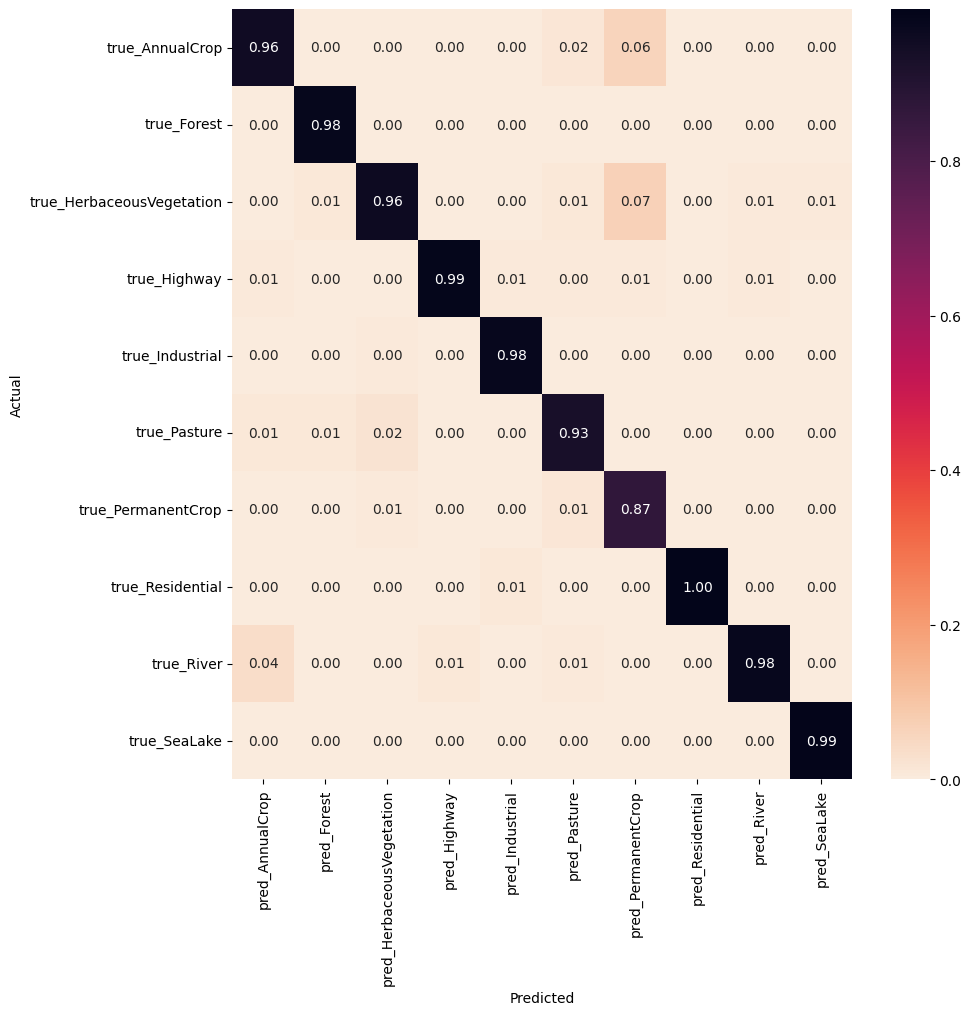

In [ ]:
cmn = tf.math.confusion_matrix(labels, predictions).numpy()

cmn = cmn.astype('float') / cmn.sum(axis=0)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f',
            xticklabels=[f"pred_{c}" for c in class_names],
            yticklabels=[f"true_{c}" for c in class_names],

            cmap="rocket_r"
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.savefig("confusion-matrix.png")
plt.show()

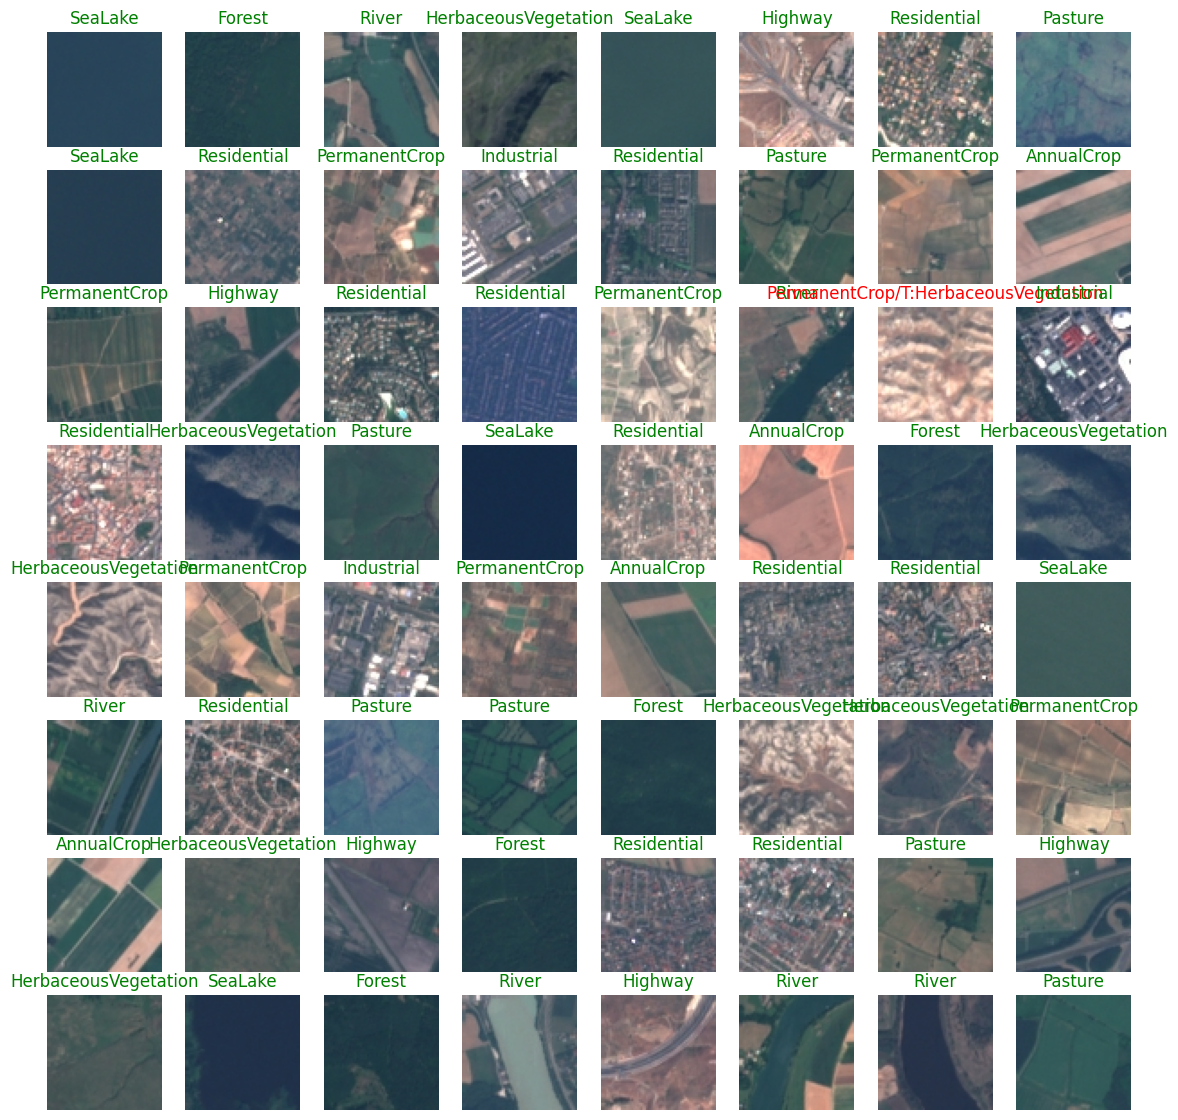

In [ ]:
def show_predicted_samples():
  plt.figure(figsize=(14, 14))
  for n in range(64):
      ax = plt.subplot(8, 8, n + 1)

      plt.imshow(images[n])

      if predictions[n] == labels[n]:

        ax.set_title(class_names[predictions[n]], color="green")
      else:

        ax.set_title(f"{class_names[predictions[n]]}/T:{class_names[labels[n]]}", color="red")
      plt.axis('off')
      plt.savefig("predicted-sample-images.png")

show_predicted_samples()